#ALTEGRAD LAB6 
CHAUVIN Paul \\
paulchauvin97@gmail.com

#Environment

In [1]:
!pip uninstall networkx
!pip install networkx==2.7

!pip uninstall scipy
!pip install scipy==1.8

Found existing installation: networkx 2.8.8
Uninstalling networkx-2.8.8:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/networkx-2.8.8.dist-info/*
    /usr/local/lib/python3.8/dist-packages/networkx/*
    /usr/local/share/doc/networkx-2.8.8/LICENSE.txt
    /usr/local/share/doc/networkx-2.8.8/examples/3d_drawing/README.txt
    /usr/local/share/doc/networkx-2.8.8/examples/3d_drawing/mayavi2_spring.py
    /usr/local/share/doc/networkx-2.8.8/examples/3d_drawing/plot_basic.py
    /usr/local/share/doc/networkx-2.8.8/examples/README.txt
    /usr/local/share/doc/networkx-2.8.8/examples/algorithms/README.txt
    /usr/local/share/doc/networkx-2.8.8/examples/algorithms/WormNet.v3.benchmark.txt
    /usr/local/share/doc/networkx-2.8.8/examples/algorithms/hartford_drug.edgelist
    /usr/local/share/doc/networkx-2.8.8/examples/algorithms/plot_beam_search.py
    /usr/local/share/doc/networkx-2.8.8/examples/algorithms/plot_betweenness_centrality.py
    /usr/local/share/doc/networkx-2.8.8/ex

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from random import randint
import scipy.sparse as sp
from scipy.sparse import coo_matrix
import scipy

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
print(scipy.__version__)
print(nx.__version__)

1.8.0
2.7


# Part 1 - Graph Attention Network for Node-Level Tasks

##Utils Part 1


In [8]:
def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

##Implementation of Graph Attention Layer

In [9]:
class GATLayer(nn.Module):
    """GAT layer"""
    def __init__(self, n_feat, n_hidden, alpha=0.05):
        super(GATLayer, self).__init__()
        self.fc = nn.Linear(n_feat, n_hidden, bias=False)
        self.a = nn.Linear(2*n_hidden, 1)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, adj):
        
        ############## Task 1
        indices =  adj.coalesce().indices()
        left_nodes = self.fc(x[indices[0]])
        right_nodes = self.fc(x[indices[1]])
        nodes = torch.cat((left_nodes, right_nodes), dim = -1)
        h = self.leakyrelu(self.a(nodes))

        h = torch.exp(h.squeeze())
        unique, inverse_indices = torch.unique(indices[0,:], return_inverse = True)
        t = torch.zeros(unique.size(0) , device=x.device)
        h_sum = t.scatter_add_(0, inverse_indices, h)
        h_norm = torch.gather(h_sum, 0, inverse_indices)
        alpha = torch.div(h, h_norm)
        adj_att = torch.sparse.FloatTensor(indices, alpha, torch.Size([x.size(0), x.size(0)])).to(x.device)
        
        out = torch.sparse.mm(adj_att, self.fc(x))

        return out, alpha

##Implementation of Graph Neural Network

In [10]:
class GNN(nn.Module):
    """GNN model"""
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GNN, self).__init__()
        self.mp1 = GATLayer(nfeat, nhid)
        self.mp2 = GATLayer(nhid, nhid)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        
        ############## Tasks 2 and 4
        x, _ = self.mp1(x, adj)
        x = self.dropout(self.relu(x))
        x, att_score = self.mp2(x, adj)
        x = self.relu(x)
        x = self.fc(x)

        return F.log_softmax(x, dim=1), att_score

##Node Classification

Number of nodes: 34
Number of edges: 78


<ipython-input-11-7ed79f8f88a0>:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G)


Epoch: 001 loss_train: 0.6987 acc_train: 0.4444 time: 0.1928s
Epoch: 002 loss_train: 0.6919 acc_train: 0.4444 time: 0.0106s
Epoch: 003 loss_train: 0.6848 acc_train: 0.4444 time: 0.0072s
Epoch: 004 loss_train: 0.6763 acc_train: 0.5556 time: 0.0039s
Epoch: 005 loss_train: 0.6653 acc_train: 0.9259 time: 0.0041s
Epoch: 006 loss_train: 0.6529 acc_train: 1.0000 time: 0.0055s
Epoch: 007 loss_train: 0.6375 acc_train: 1.0000 time: 0.0052s
Epoch: 008 loss_train: 0.6135 acc_train: 1.0000 time: 0.0035s
Epoch: 009 loss_train: 0.5940 acc_train: 1.0000 time: 0.0037s
Epoch: 010 loss_train: 0.5664 acc_train: 1.0000 time: 0.0054s
Epoch: 011 loss_train: 0.5389 acc_train: 1.0000 time: 0.0040s
Epoch: 012 loss_train: 0.4885 acc_train: 1.0000 time: 0.0036s
Epoch: 013 loss_train: 0.4632 acc_train: 0.9630 time: 0.0036s
Epoch: 014 loss_train: 0.3960 acc_train: 1.0000 time: 0.0036s
Epoch: 015 loss_train: 0.3294 acc_train: 1.0000 time: 0.0035s
Epoch: 016 loss_train: 0.2840 acc_train: 1.0000 time: 0.0037s
Epoch: 0

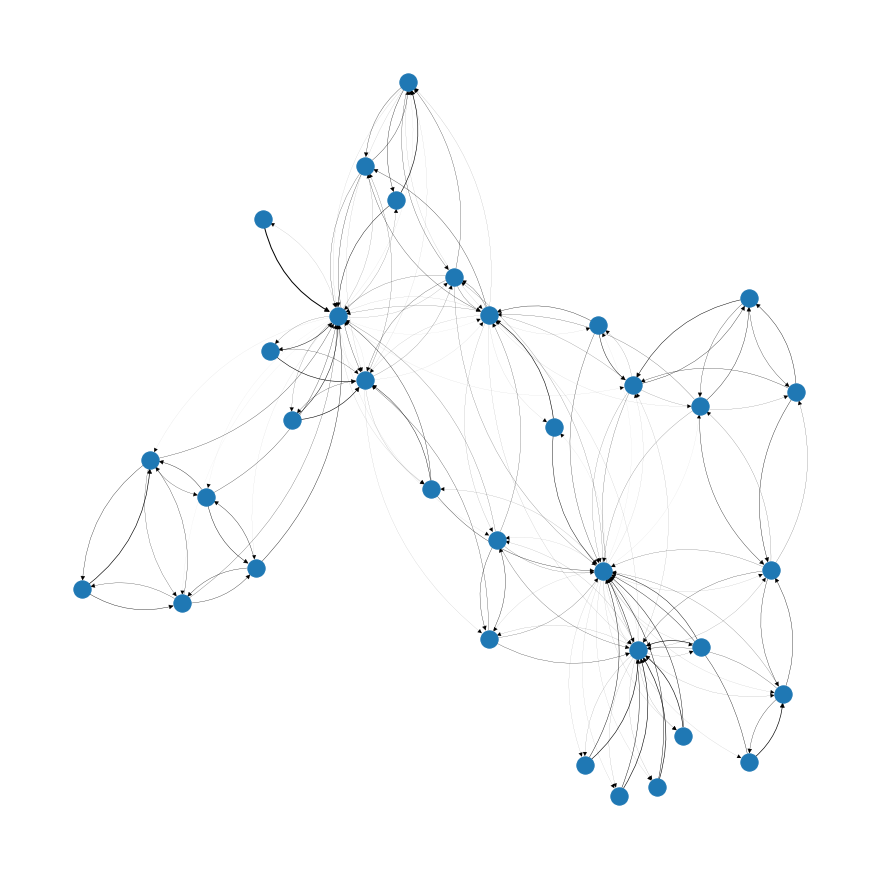

In [11]:
# Hyperparameters
epochs = 200
n_hidden = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_6_Deep_Learning_for_Graphs_II/code/data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_6_Deep_Learning_for_Graphs_II/code/data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

############## Task 3
adj = nx.adjacency_matrix(G)
features = np.random.randn(n, n_hidden)

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, _ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")

# Testing
model.eval()
output, alpha = model(features, adj)
loss_test = F.nll_loss(output[idx_test], y[idx_test])
acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test))


############## Task 4
alpha = alpha.detach().cpu().numpy()

# Dictionary that maps indices of nodes to nodes
idx_to_node = dict()
for i,node in enumerate(G.nodes()):
    idx_to_node[i] = node

# Creates a directed karate network
G_directed = G.to_directed()

# Retrieves nonzero indices of the adjacency matrix
indices = adj.coalesce().indices().detach().cpu().numpy()

# Annotates edges with the learned attention weights 
for i in range(indices.shape[1]):
    G_directed[idx_to_node[indices[0,i]]][idx_to_node[indices[1,i]]]['weight'] = alpha[i]

weights = [G_directed[u][v]['weight'] for u,v in G_directed.edges()]

# Visualizes attention weights
plt.figure(1,figsize=(12,12))
pos = nx.spring_layout(G_directed)
arc_rad = 0.25
nx.draw(G_directed, width=weights, connectionstyle=f'arc3, rad = {arc_rad}')
plt.show()

#Part 2 - Graph Neural Networks for Graph-Level Tasks

##Utils/Dataset creation - Part 2

In [68]:
#Useful functions Part 2
def create_dataset():
    Gs = list()
    y = list()
    n=randint(10,20)
    ############## Task 5
    for i in range(50):
      G = nx.fast_gnp_random_graph(n, p=0.2)
      Gs.append(G)
      y.append(0) 

    for i in range(50):
      G = nx.fast_gnp_random_graph(n, p=0.4)
      Gs.append(G)
      y.append(1)
    return Gs, y

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

##Implementation of Graph Neural Network

In [69]:
class GNN(nn.Module):
    def init(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class, device):
        super(GNN, self).init()
        self.device = device
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        A = torch.eye(adj.size(0)) + adj
        x = self.relu(self.fc1(torch.matmul(A, x_in)))
        x = self.fc2(torch.sparse.mm(A, x))
        m = torch.max(idx) + 1
        m = m.item()
        m = int(m)
        m2 = int(x.size(1))
        idx = idx.unsqueeze(1).repeat(1, m2)
        out = torch.zeros((m, m2)).to(self.device)
        out = out.scatteradd(0, idx.type(dtype = torch.int64), x) 
        out = self.fc4(self.relu(self.fc3(out)))
        return F.log_softmax(out, dim=1)

##Graph Classification

In [70]:
# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        #y_batch = list()

        G_batch = G_train[i:i + batch_size]
        ############## Task 7
        adj_batch = [nx.adjacency_matrix(G) for G in G_batch]
        adj_batch = sp.block_diag(adj_batch)
        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch)
        features_batch = torch.ones((adj_batch.size(0),1))
        for j, G in enumerate(G_batch):
          idx_batch.append(j*torch.ones(G.number_of_nodes()))
        idx_batch = torch.cat(idx_batch)
        y_batch = y_train[i:i + batch_size]
        y_batch = torch.Tensor(y_batch)

        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch.type(torch.int64))
        train_loss += loss.item()*output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')

# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    #y_batch = list()

    G_batch = G_test[i:i + batch_size]
    ############## Task 7
    adj_batch = [nx.adjacency_matrix(G) for G in G_batch]
    adj_batch = sp.block_diag(adj_batch)
    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch)
    features_batch = torch.ones((adj_batch.size(0),1))
    for j, G in enumerate(G_batch):
      idx_batch.append(j*torch.ones(G.number_of_nodes()))
    idx_batch = torch.cat(idx_batch)
    y_batch = y_test[i:i + batch_size]
    y_batch = torch.Tensor(y_batch)

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch.type(torch.int64))
    test_loss += loss.item()*output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))


TypeError: ignored